In [359]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
import geocoder # import geocoder
import folium

import json 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler

Scraping the data

In [361]:

url = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
#print(soup.prettify())
right_table=soup.find('table', class_='wikitable sortable')
df = pd.read_html(str(right_table))
print(df)

[     Image                                            Stadium         City  \
0      NaN                             Aggie Memorial Stadium   Las Cruces   
1      NaN                                          Alamodome  San Antonio   
2      NaN             Alaska Airlines Field at Husky Stadium      Seattle   
3      NaN                                 Albertsons Stadium        Boise   
4      NaN                           Allen E. Paulson Stadium   Statesboro   
..     ...                                                ...          ...   
125    NaN  Veterans Memorial Stadium at Larry Blakeney Field         Troy   
126    NaN                                      Waldo Stadium    Kalamazoo   
127    NaN                      Warren McGuirk Alumni Stadium       Hadley   
128    NaN    Wayne Day Family Field at Carter–Finley Stadium      Raleigh   
129    NaN                             Williams-Brice Stadium     Columbia   

    State              Team     Conference     Capacity  \
0  

Cleaning the data and getting geolocation data

In [363]:
df_new = df[0]
#df_new =df[0].replace(to_replace = '\[[0-9A-Z]*\]',value = '', regex = True)
#df_new['Capacity'] =df_new['Capacity'].replace(to_replace = ',',value = '', regex = True)
#df_new['Built'] =df_new['Built'].replace(to_replace = '\([.*]\)',value = '', regex = True)

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

latitude = []
longitude = []
# loop until you get the coordinates
for index, row in df_new.iterrows():
    g = geocoder.arcgis('{}, {}, {}'.format(row['Stadium'],row['City'],states[row.State]))
    latitude.append(g.latlng[0])
    longitude.append(g.latlng[1])
    print(row['Stadium'])
    


Aggie Memorial Stadium
Alamodome
Alaska Airlines Field at Husky Stadium
Albertsons Stadium
Allen E. Paulson Stadium
Aloha Stadium
Alumni Stadium
Amon G. Carter Stadium
Apogee Stadium
Arizona Stadium
Arthur L. Williams Stadium
Autzen Stadium
Bagwell Field at Dowdy–Ficklen Stadium
BB&T Field
Beaver Stadium
Benson Field at Yulman Stadium
Bill Snyder Family Football Stadium
Blaik Field at Michie Stadium
Bobby Bowden Field at Doak S. Campbell Stadium
Bobby Dodd Stadium at Historic Grant Field
Boone Pickens Stadium
Brigham Field at Huskie Stadium
Brooks Field at Wallace Wade Stadium
Brooks Stadium
Bryant–Denny Stadium
Bulldog Stadium at Jim Sweeney Field
Cajun Field
California Memorial Stadium
Camp Randall Stadium
Capital One Field at Maryland Stadium
Cardinal Stadium[36]
Carl Smith Center, Home of David A. Harrison III Field at Scott Stadium
Carlisle-Faulkner Field at M.M. Roberts Stadium
Carrier Dome
CEFCU Stadium
Centennial Bank Stadium
Darrell K Royal–Texas Memorial Stadium
David Booth K

In [364]:
df_new.head()

,Image,Stadium,City,State,Team,Conference,Capacity,Record1,Built,Expanded 2,Surface
0,NaN,Aggie Memorial Stadium,Las Cruces,NM,New Mexico State,Independent,"30,343[1]","32,993(September 26, 1998 vs. UTEP)[1]",1978[1],2005[1],S5-M Synthetic Turf
1,NaN,Alamodome,San Antonio,TX,UTSA,C-USA,65000,"56,743(September 3, 2011 vs. Northeastern State)",1993,NaN,SportField
2,NaN,Alaska Airlines Field at Husky Stadium,Seattle,WA,Washington,Pac-12,"70,500[2]","76,125(September 23, 1995 vs. Army)",1920,2013,FieldTurf
3,NaN,Albertsons Stadium,Boise,ID,Boise State,Mountain West,"36,387[3]","36,864(September 20, 2012 vs. BYU)[4]",1970[3],2012[3],Smurf Turf
4,NaN,Allen E. Paulson Stadium,Statesboro,GA,Georgia Southern,Sun Belt,25000,"25,735(September 17, 2016 vs. Louisiana-Monroe)",1984,2014,Shaw Legion 41 Synthetic Turf


In [365]:
import requests
pop = []
def get_city_opendata(city, country):
    tmp = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q=%s&sort=population&facet=country&refine.country=%s'
    cmd = tmp % (city, country)
    res = requests.get(cmd)
    dct = json.loads(res.content)
    out = dct['records'][0]['fields']
    return out

stad_loc = df_new
stad_loc['Latitude'] = latitude
stad_loc['Longitude'] = longitude
for index, row in stad_loc.iterrows():
    try:
        pop.append(get_city_opendata(row.City,'us')['population'])
    except:
        #If no population, replace with 10000
        pop.append(10000)
stad_loc['Population'] = pop

    

    


Preparing Map of stadia

In [366]:
stad_loc.head()

,Image,Stadium,City,State,Team,Conference,Capacity,Record1,Built,Expanded 2,Surface,Latitude,Longitude,Population
0,NaN,Aggie Memorial Stadium,Las Cruces,NM,New Mexico State,Independent,"30,343[1]","32,993(September 26, 1998 vs. UTEP)[1]",1978[1],2005[1],S5-M Synthetic Turf,32.28163,-106.74150,80184
1,NaN,Alamodome,San Antonio,TX,UTSA,C-USA,65000,"56,743(September 3, 2011 vs. Northeastern State)",1993,NaN,SportField,29.41806,-98.47887,1256810
2,NaN,Alaska Airlines Field at Husky Stadium,Seattle,WA,Washington,Pac-12,"70,500[2]","76,125(September 23, 1995 vs. Army)",1920,2013,FieldTurf,47.65090,-122.30340,569369
3,NaN,Albertsons Stadium,Boise,ID,Boise State,Mountain West,"36,387[3]","36,864(September 20, 2012 vs. BYU)[4]",1970[3],2012[3],Smurf Turf,43.60242,-116.19469,10000
4,NaN,Allen E. Paulson Stadium,Statesboro,GA,Georgia Southern,Sun Belt,25000,"25,735(September 17, 2016 vs. Louisiana-Monroe)",1984,2014,Shaw Legion 41 Synthetic Turf,32.41121,-81.78143,24558


In [367]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Wichita, Kansas'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat_wich = location.latitude
long_wich = location.longitude
print('The geographical coordinate of Wichita are {}, {}.'.format(latitude, longitude))
map_us = folium.Map(location=[lat_wich, long_wich], zoom_start=3)



The geographical coordinate of Wichita are [32.281630000000064, 29.41805994604498, 47.65089994388065, 43.60242002279395, 32.41121000000004, 21.306399918345416, 42.33417000000003, 32.71023992555874, 33.202690000000075, 32.227940000000046, 37.432385115442536, 44.0558100617454, 35.59558000000004, 36.13054000000005, 40.81137000000007, 29.94446008107778, 39.20329000000004, 41.38757000000004, 30.439770000000067, 33.77233000000007, 36.12563000000006, 41.93331995383528, 35.592552, 33.79349000000008, 33.209079960905356, 36.81439000000006, 30.214250030007328, 37.870870000000025, 43.06937000000005, 38.99147000000005, 38.19914000000006, 38.03213000000005, 31.344728214278966, 43.03564003346884, 37.3207199427268, 35.84899997576569, 30.283450040538938, 38.962860000000035, 33.45547000000005, 41.13909000000007, 41.37997000000007, 35.06705000000005, 38.80929372075947, 26.374799945468098, 38.936060000000055, 40.01626647370109, 33.42505994445755, 34.68268000000006, 39.520110000000045, 35.20434000000006, 3

In [368]:
# add markers to map
#nconf=stad_loc['Conference'].nunique()
#x = np.arange(nconf)
#ys = [i + x + (i*x)**2 for i in range(nconf)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colordict = {0: 'lightblue', 1: 'lightgreen', 2: 'orange', 3: 'red', 4:'yellow',5:'darkgreen',6:'black',7:'purple',8:'pink',9:'cadetblue',10:'darkred', 11:'white'}
            
stad_loc.Conference = pd.Categorical(stad_loc.Conference)
stad_loc['ConfCode'] = stad_loc['Conference'].cat.codes
# add markers to the map
for index, row in stad_loc.iterrows():

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=folium.Popup(row.Team + ': ' +  row.Stadium, parse_html=True),
        color=colordict[row.ConfCode],
        fill=True,
        fill_color=colordict[row.ConfCode],
        fill_opacity=0.7).add_to(map_us)


map_us

Foursquare

In [377]:
CLIENT_ID = 'P3LFOI0HUBKFQDALQZ2VOV3NIZLPCWKMWROPMYMLPMANEO0J' # your Foursquare ID
CLIENT_SECRET = 'QO0JSK5QW42O2K3JJBSXZRDSBEGHPC5AR20EIO5D40RWCE0F' 
VERSION = '20180605'
LIMIT = 2
radius = 1500

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Stadium', 
                  'Stadium Latitude', 
                  'Stadium Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [378]:
test_venues = getNearbyVenues(names=stad_loc['Stadium'],
                                   latitudes=stad_loc['Latitude'],
                                   longitudes=stad_loc['Longitude'], 
                                   radius = 1500,
                                   limit = 100
                                  )
print(test_venues)

Aggie Memorial Stadium 32.281630000000064 -106.74149999999997
Alamodome 29.41805994604498 -98.47887007660563
Alaska Airlines Field at Husky Stadium 47.65089994388065 -122.30339995210447
Albertsons Stadium 43.60242002279395 -116.19469004674164
Allen E. Paulson Stadium 32.41121000000004 -81.78143005554247
Aloha Stadium 21.306399918345416 -157.85620998052426
Alumni Stadium 42.33417000000003 -71.16637999999995
Amon G. Carter Stadium 32.71023992555874 -97.3671300644866
Apogee Stadium 33.202690000000075 -97.15960999999999
Arizona Stadium 32.227940000000046 -110.94806999999997
Arthur L. Williams Stadium 37.432385115442536 -79.12043546627079
Autzen Stadium 44.0558100617454 -123.067429940419
Bagwell Field at Dowdy–Ficklen Stadium 35.59558000000004 -77.36610999999994
BB&T Field 36.13054000000005 -80.25449999999995
Beaver Stadium 40.81137000000007 -77.85470999999995
Benson Field at Yulman Stadium 29.94446008107778 -90.11556000230765
Bill Snyder Family Football Stadium 39.20329000000004 -96.593819

In [379]:
# one hot encoding
stad_onehot = pd.get_dummies(test_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stad_onehot['Stadium'] = test_venues['Stadium'] 
cols = list(stad_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Stadium')))

stad_onehot = stad_onehot[cols]
stad_onehot.head()


,Stadium,ATM,Accessories Store,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aggie Memorial Stadium,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aggie Memorial Stadium,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aggie Memorial Stadium,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aggie Memorial Stadium,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aggie Memorial Stadium,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [381]:
my_cols = ['Stadium','American Restaurant','BBQ Joint', 'Bar','Beer Bar','Beer Garden','Breakfast Spot','Brewery', 
          'Burger Joint', 'Burrito Place', 'Chinese Restaurant', 'Cocktail Bar', 'Coffee Shop','Diner', 'Donut Shop',
           'Food Truck', 'Hot Dog Joint', 'Fast Food Restaurant', 
          'Gastropub', 'Italian Restaurant', 'Mexican Restaurant', 'New American Restaurant', 
          'Pizza Place',  'Sports Bar', 'Pub', 'Sandwich Place', 'Seafood Restaurant', 
          'Steakhouse', 'Taco Place',  'Wine Shop']
sum_cols = ['American Restaurant','BBQ Joint', 'Bar','Beer Bar','Beer Garden','Breakfast Spot','Brewery', 
          'Burger Joint', 'Burrito Place', 'Chinese Restaurant', 'Cocktail Bar', 'Coffee Shop','Diner', 'Donut Shop',
           'Food Truck', 'Hot Dog Joint', 'Fast Food Restaurant', 
          'Gastropub', 'Italian Restaurant', 'Mexican Restaurant', 'New American Restaurant', 
          'Pizza Place',  'Sports Bar', 'Pub', 'Sandwich Place', 'Seafood Restaurant', 
          'Steakhouse', 'Taco Place',  'Wine Shop']
stad_subset = stad_onehot[my_cols]
stad_subset['sum'] = stad_subset[sum_cols].sum(axis=1)
stad_subset = stad_subset[stad_subset['sum'] != 0]
stad_subset.head



C:\Users\draper.34\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<bound method NDFrame.head of                      Stadium  American Restaurant  BBQ Joint  Bar  Beer Bar  \
3     Aggie Memorial Stadium                    0          0    0         0   
5     Aggie Memorial Stadium                    0          0    0         0   
6     Aggie Memorial Stadium                    0          0    0         0   
9     Aggie Memorial Stadium                    1          0    0         0   
12    Aggie Memorial Stadium                    0          0    0         0   
...                      ...                  ...        ...  ...       ...   
8210  Williams-Brice Stadium                    0          0    0         0   
8211  Williams-Brice Stadium                    0          1    0         0   
8212  Williams-Brice Stadium                    0          0    0         0   
8222  Williams-Brice Stadium                    1          0    0         0   
8223  Williams-Brice Stadium                    0          0    1         0   

      Beer Garden  Br

In [427]:
stad_grouped = stad_subset.groupby('Stadium').mean().reset_index()


stad_grouped.head()

#for cols in stad_grouped.columns:
#    print(cols)

,Stadium,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,...,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,sum
0,Aggie Memorial Stadium,0.066667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.000000,0.066667,0.000000,0.066667,0.133333,0.0,0.000000,0.00000,0.000000,1
1,Alamodome,0.100000,0.066667,0.033333,0.00000,0.066667,0.000000,0.033333,0.033333,0.000000,...,0.066667,0.000000,0.066667,0.000000,0.100000,0.1,0.100000,0.00000,0.000000,1
2,Alaska Airlines Field at Husky Stadium,0.000000,0.000000,0.000000,0.00000,0.041667,0.041667,0.000000,0.083333,0.000000,...,0.041667,0.125000,0.000000,0.041667,0.125000,0.0,0.000000,0.00000,0.000000,1
3,Albertsons Stadium,0.024390,0.000000,0.121951,0.02439,0.000000,0.048780,0.048780,0.073171,0.000000,...,0.024390,0.195122,0.000000,0.024390,0.097561,0.0,0.000000,0.02439,0.000000,1
4,Allen E. Paulson Stadium,0.000000,0.076923,0.000000,0.00000,0.000000,0.153846,0.000000,0.000000,0.076923,...,0.000000,0.230769,0.076923,0.000000,0.153846,0.0,0.076923,0.00000,0.076923,1


In [414]:
stad_loc =stad_loc.replace(to_replace = '\[[A-Z 0-9]*\]',value = '', regex = True)
stad_loc['Capacity'] =stad_loc['Capacity'].replace(to_replace = ',',value = '', regex = True)
stad_loc['Capacity'] =stad_loc['Capacity'].replace(to_replace = '\[0-9 A-Z\]',value = '', regex = True)
stad_loc['Built'] =stad_loc['Built'].replace(to_replace = '\(.*\)',value = '', regex = True)
stad_loc.head()
stad_sub = pd.merge(stad_grouped, stad_loc,on = 'Stadium')
stad_sub.drop('sum', axis = 1)
stad_sub.head()

,Stadium,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,...,Conference,Capacity,Record1,Built,Expanded 2,Surface,Latitude,Longitude,Population,ConfCode
0,Aggie Memorial Stadium,0.066667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.066667,0.000000,...,Independent,30343,"32,993(September 26, 1998 vs. UTEP)",1978,2005,S5-M Synthetic Turf,32.28163,-106.74150,80184,5
1,Alamodome,0.100000,0.066667,0.033333,0.00000,0.066667,0.000000,0.033333,0.033333,0.000000,...,C-USA,65000,"56,743(September 3, 2011 vs. Northeastern State)",1993,NaN,SportField,29.41806,-98.47887,1256810,4
2,Alaska Airlines Field at Husky Stadium,0.000000,0.000000,0.000000,0.00000,0.041667,0.041667,0.000000,0.083333,0.000000,...,Pac-12,70500,"76,125(September 23, 1995 vs. Army)",1920,2013,FieldTurf,47.65090,-122.30340,569369,9
3,Albertsons Stadium,0.024390,0.000000,0.121951,0.02439,0.000000,0.048780,0.048780,0.073171,0.000000,...,Mountain West,36387,"36,864(September 20, 2012 vs. BYU)",1970,2012,Smurf Turf,43.60242,-116.19469,10000,8
4,Allen E. Paulson Stadium,0.000000,0.076923,0.000000,0.00000,0.000000,0.153846,0.000000,0.000000,0.076923,...,Sun Belt,25000,"25,735(September 17, 2016 vs. Louisiana-Monroe)",1984,2014,Shaw Legion 41 Synthetic Turf,32.41121,-81.78143,24558,11


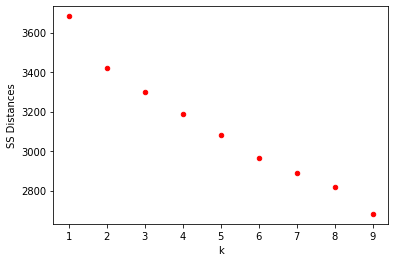

In [428]:
stad_grouped = stad_grouped.drop(['Stadium'], axis = 1)
Clus_dataSet = StandardScaler().fit_transform(stad_grouped)
Clus_dataSet
where_are_NaNs = isnan(Clus_dataSet)
Clus_dataSet[where_are_NaNs] = 0
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Clus_dataSet)
    Sum_of_squared_distances.append(km.inertia_)
df = pd.DataFrame(zip(K, Sum_of_squared_distances), columns =['k', 'SS Distances'])
df
df.plot(kind='scatter',x='k',y='SS Distances',color='red')


In [416]:
from numpy import *
stad_grouped_clustering = stad_sub.drop(['Stadium', 'City','Conference','Image', 'Team','Record1','Built', 'Expanded 2','Surface', 'Latitude','Longitude','State'], axis = 1)
#stad_grouped_clustering['Capacity'] = stad_grouped_clustering['Capacity'].astype(int)
stad_grouped_clustering.head()

Clus_dataSet = StandardScaler().fit_transform(stad_grouped_clustering)
Clus_dataSet
where_are_NaNs = isnan(Clus_dataSet)
Clus_dataSet[where_are_NaNs] = 0

In [417]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Clus_dataSet)
    Sum_of_squared_distances.append(km.inertia_)

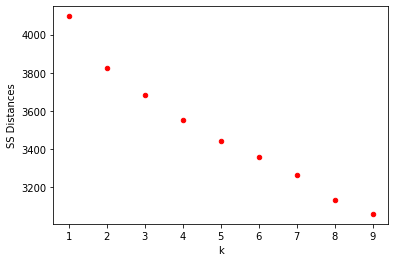

In [418]:
df = pd.DataFrame(zip(K, Sum_of_squared_distances), columns =['k', 'SS Distances'])
df
df.plot(kind='scatter',x='k',y='SS Distances',color='red')


In [419]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
print(labels)


[0 4 3 4 3 4 3 0 0 0 0 0 1 0 2 4 2 2 4 4 2 0 4 0 2 0 4 0 4 2 0 2 4 0 2 0 4
 2 0 2 0 0 0 0 2 3 2 3 2 2 4 4 0 2 4 0 2 0 2 0 0 0 4 0 0 2 0 4 3 3 0 0 2 0
 0 2 0 4 1 4 0 0 0 2 3 3 4 0 2 3 3 2 0 2 4 3 3 2 0 3 3 0 2 2 3 0 0 3 0 4 0
 0 4 2 0 3 2 4 0 0 0 3 2 0 3 3 1 4]


In [451]:
stad_sub["Clus_km"] = labels
stad_sub.head(5)

clustered_groups_col = ['Clus_km','Stadium', 'Team', 'Conference','City','State', 'Population','Capacity', 'American Restaurant','BBQ Joint', 'Bar','Beer Bar','Beer Garden','Breakfast Spot','Brewery', 
          'Burger Joint', 'Burrito Place', 'Chinese Restaurant', 'Cocktail Bar', 'Coffee Shop','Diner', 'Donut Shop',
           'Food Truck', 'Hot Dog Joint', 'Fast Food Restaurant', 
          'Gastropub', 'Italian Restaurant', 'Mexican Restaurant', 'New American Restaurant', 
          'Pizza Place',  'Sports Bar', 'Pub', 'Sandwich Place', 'Seafood Restaurant', 
          'Steakhouse', 'Taco Place',  'Wine Shop', 'Latitude', 'Longitude']
clustered_groups = stad_sub[clustered_groups_col]
clustered_groups[clustered_groups['Clus_km']==0]



,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
0,0,Aggie Memorial Stadium,New Mexico State,Independent,Las Cruces,NM,80184,30343,0.066667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.200000,0.000000,0.000000,0.066667,0.000000,0.133333,0.0,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,0.133333,0.000000,0.000000,0.000000,0.000000,32.281630,-106.741500
7,0,Amon G. Carter Stadium,TCU,Big 12,Fort Worth,TX,618119,45000,0.045455,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.136364,0.000000,0.000000,0.000000,0.090909,0.000000,0.045455,0.000000,0.000000,0.090909,0.0,0.000000,0.090909,0.000000,0.318182,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,32.710240,-97.367130
8,0,Apogee Stadium,North Texas,C-USA,Denton,TX,100975,30850,0.000000,0.000000,0.090909,0.00000,0.000000,0.090909,0.000000,0.090909,0.000000,0.181818,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,33.202690,-97.159610
9,0,Arizona Stadium,Arizona,Pac-12,Tucson,AZ,518907,56029,0.048780,0.024390,0.073171,0.00000,0.024390,0.000000,0.024390,0.000000,0.000000,0.048780,0.000000,0.170732,0.024390,0.024390,0.000000,0.024390,0.048780,0.0,0.000000,0.121951,0.000000,0.097561,0.024390,0.024390,0.195122,0.000000,0.000000,0.000000,0.000000,32.227940,-110.948070
10,0,Arthur L. Williams Stadium,Liberty,Independent (2018),Lynchburg,VA,65517,25000,0.083333,0.083333,0.000000,0.00000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667,0.0,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.432385,-79.120435
11,0,Autzen Stadium,Oregon,Pac-12,Eugene,OR,145208,54000,0.052632,0.026316,0.026316,0.00000,0.000000,0.026316,0.026316,0.026316,0.000000,0.131579,0.026316,0.184211,0.000000,0.000000,0.000000,0.000000,0.026316,0.0,0.026316,0.131579,0.000000,0.105263,0.078947,0.026316,0.052632,0.000000,0.000000,0.000000,0.026316,44.055810,-123.067430
13,0,Bagwell Field at Dowdy–Ficklen Stadium,East Carolina,American,Greenville,NC,70757,50000,0.000000,0.000000,0.032258,0.00000,0.000000,0.032258,0.000000,0.161290,0.000000,0.000000,0.000000,0.225806,0.000000,0.032258,0.000000,0.000000,0.161290,0.0,0.032258,0.064516,0.000000,0.096774,0.032258,0.000000,0.096774,0.000000,0.032258,0.000000,0.000000,35.595580,-77.366110
21,0,Brigham Field at Huskie Stadium,NIU,MAC,DeKalb,IL,43383,23595,0.062500,0.000000,0.062500,0.00000,0.000000,0.031250,0.000000,0.000000,0.031250,0.062500,0.000000,0.062500,0.031250,0.031250,0.000000,0.000000,0.062500,0.0,0.000000,0.093750,0.000000,0.250000,0.000000,0.000000,0.218750,0.000000,0.000000,0.000000,0.000000,41.933320,-88.777030
23,0,Brooks Stadium,Coastal Carolina,Sun Belt,Conway,SC,51524,20000,0.000000,0.000000,0.000000,0.00000,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.0,0.000000,0.090909,0.000000,0.181818,0.090909,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,33.793490,-79.016240
25,0,Bulldog Stadium at Jim Sweeney Field,Fresno State,Mountain West,Fresno,CA,465183,41031,0.052632,0.000000,0.000000,0.00000,0.000000,0.052632,0.000000,0.105263,0.000000,0.210526,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.052632,0.052632,0.000000,0.052632,0.000000,0.000000,0.157895,0.052632,0.000000,0.052632,0.000000,36.814390,-119.757920


In [441]:
colordict = {0: 'cadetblue', 1: 'lightgreen', 2: 'black', 3: 'red', 4:'yellow',5:'darkgreen',6:'black',7:'purple',8:'pink',9:'cadetblue',10:'darkred', 11:'white'}
            

# add markers to the map
for index, row in clustered_groups.iterrows():

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=folium.Popup(row.Team + ': ' +  row.Stadium, parse_html=True),
        color=colordict[row.Clus_km],
        fill=True,
        fill_color=colordict[row.Clus_km],
        fill_opacity=0.7).add_to(map_us)


map_us

In [450]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Stadium']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
# create a new dataframe
stad_venues_sorted = pd.DataFrame(columns=columns)
stad_venues_sorted['Stadium'] = stad_grouped['Stadium']

for ind in np.arange(stad_grouped.shape[0]):
    stad_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stad_grouped.iloc[ind, :], num_top_venues)

stad_venues_sorted.head()

KeyError: 'Stadium'

In [452]:

clustered_groups


,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
0,0,Aggie Memorial Stadium,New Mexico State,Independent,Las Cruces,NM,80184,30343,0.066667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.200000,0.000000,0.000000,0.066667,0.0,0.133333,0.00000,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,0.133333,0.0,0.000000,0.000000,0.000000,32.28163,-106.74150
1,4,Alamodome,UTSA,C-USA,San Antonio,TX,1256810,65000,0.100000,0.066667,0.033333,0.00000,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.000000,0.0,0.033333,0.00000,0.033333,0.066667,0.066667,0.000000,0.066667,0.000000,0.100000,0.1,0.100000,0.000000,0.000000,29.41806,-98.47887
2,3,Alaska Airlines Field at Husky Stadium,Washington,Pac-12,Seattle,WA,569369,70500,0.000000,0.000000,0.000000,0.00000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.000000,0.250000,0.041667,0.000000,0.000000,0.0,0.000000,0.00000,0.083333,0.083333,0.041667,0.125000,0.000000,0.041667,0.125000,0.0,0.000000,0.000000,0.000000,47.65090,-122.30340
3,4,Albertsons Stadium,Boise State,Mountain West,Boise,ID,10000,36387,0.024390,0.000000,0.121951,0.02439,0.000000,0.048780,0.048780,0.073171,0.000000,0.024390,0.024390,0.097561,0.000000,0.000000,0.000000,0.0,0.048780,0.02439,0.000000,0.073171,0.024390,0.195122,0.000000,0.024390,0.097561,0.0,0.000000,0.024390,0.000000,43.60242,-116.19469
4,3,Allen E. Paulson Stadium,Georgia Southern,Sun Belt,Statesboro,GA,24558,25000,0.000000,0.076923,0.000000,0.00000,0.000000,0.153846,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.230769,0.076923,0.000000,0.153846,0.0,0.076923,0.000000,0.076923,32.41121,-81.78143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0,Veterans Memorial Stadium at Larry Blakeney Field,Troy,Sun Belt,Troy,AL,81269,30402,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,31.79821,-85.95142
124,3,Waldo Stadium,Western Michigan,MAC,Kalamazoo,MI,74138,30200,0.115385,0.000000,0.000000,0.00000,0.000000,0.153846,0.038462,0.000000,0.000000,0.076923,0.000000,0.153846,0.000000,0.000000,0.038462,0.0,0.000000,0.00000,0.076923,0.000000,0.000000,0.115385,0.038462,0.038462,0.115385,0.0,0.000000,0.038462,0.000000,42.28637,-85.60177
125,3,Warren McGuirk Alumni Stadium,UMass,Independent,Hadley,MA,17652,17000,0.115385,0.000000,0.153846,0.00000,0.000000,0.038462,0.038462,0.000000,0.038462,0.038462,0.000000,0.115385,0.038462,0.076923,0.000000,0.0,0.000000,0.00000,0.038462,0.038462,0.038462,0.076923,0.076923,0.000000,0.076923,0.0,0.000000,0.000000,0.000000,42.37735,-72.53429
126,1,Wayne Day Family Field at Carter–Finley Stadium,NC State,ACC,Raleigh,NC,338759,57583,0.250000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,35.80002,-78.72082


In [448]:
pd.set_option('display.max_columns', 999)
clustered_groups.groupby('Clus_km').mean()

,Population,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
Clus_km,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,182483.980000,0.054852,0.014913,0.023932,0.000625,0.001202,0.030502,0.006142,0.051840,0.004097,0.059042,0.000526,0.120286,0.010408,0.037711,0.004901,0.008224,0.133017,0.000000,0.019234,0.098454,0.000714,0.138699,0.015372,0.007463,0.135727,0.011470,0.005436,0.003968,0.001241,36.806223,-94.595681
1,661775.666667,0.113636,0.020833,0.030303,0.000000,0.000000,0.000000,0.000000,0.071970,0.000000,0.030303,0.000000,0.104167,0.000000,0.051136,0.051136,0.000000,0.030303,0.000000,0.051136,0.000000,0.000000,0.020833,0.176136,0.104167,0.092803,0.020833,0.030303,0.000000,0.000000,37.277673,-78.047400
2,128487.533333,0.125449,0.009661,0.135668,0.001906,0.008580,0.023457,0.009285,0.026123,0.009402,0.029214,0.001621,0.130046,0.011751,0.014930,0.009105,0.002972,0.066322,0.004458,0.009638,0.063668,0.000000,0.113527,0.022268,0.016338,0.124491,0.009710,0.012829,0.007582,0.000000,37.038253,-88.581726
3,214340.904762,0.066137,0.010495,0.055308,0.001221,0.002997,0.042795,0.016581,0.044523,0.021145,0.037111,0.000972,0.133667,0.014607,0.024006,0.012627,0.006077,0.032002,0.012931,0.058098,0.068840,0.031332,0.105532,0.018723,0.018062,0.099207,0.010254,0.026703,0.012585,0.015463,38.346525,-88.599560
4,546920.375000,0.084609,0.031231,0.090032,0.009842,0.015405,0.023018,0.061879,0.039973,0.001603,0.021386,0.025026,0.103626,0.010015,0.005432,0.024215,0.014662,0.030431,0.014969,0.022219,0.070609,0.023228,0.092777,0.018145,0.011008,0.070461,0.033977,0.026888,0.020300,0.003031,34.295960,-97.136922


In [453]:
pd.crosstab(index = clustered_groups['Clus_km'],columns=clustered_groups['Conference'])

Conference,ACC,American,Big 12,Big Ten,C-USA,Independent,Independent (2018),MAC,Mountain West,Pac-12,SEC,Sun Belt
Clus_km,,,,,,,,,,,,
0,0,3,1,2,10,3,1,7,8,5,3,7
1,2,1,0,0,0,0,0,0,0,0,0,0
2,5,2,7,6,0,1,0,2,0,1,6,0
3,1,1,0,5,2,2,0,2,0,4,2,2
4,6,4,1,1,2,0,0,0,4,2,3,1


In [439]:
clustered_groups[clustered_groups['Team'] == 'Ohio State']

,Clus_km,Stadium,Team,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,...,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
93,2,Ohio Stadium,Ohio State,Columbus,OH,736836,102780,0.0,0.0,0.235294,...,0.176471,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,40.00305,-83.01945


In [454]:
clustered_groups[clustered_groups['Clus_km']==0]

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
0,0,Aggie Memorial Stadium,New Mexico State,Independent,Las Cruces,NM,80184,30343,0.066667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.200000,0.000000,0.000000,0.066667,0.000000,0.133333,0.0,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,0.133333,0.000000,0.000000,0.000000,0.000000,32.281630,-106.741500
7,0,Amon G. Carter Stadium,TCU,Big 12,Fort Worth,TX,618119,45000,0.045455,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.136364,0.000000,0.000000,0.000000,0.090909,0.000000,0.045455,0.000000,0.000000,0.090909,0.0,0.000000,0.090909,0.000000,0.318182,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,32.710240,-97.367130
8,0,Apogee Stadium,North Texas,C-USA,Denton,TX,100975,30850,0.000000,0.000000,0.090909,0.00000,0.000000,0.090909,0.000000,0.090909,0.000000,0.181818,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,33.202690,-97.159610
9,0,Arizona Stadium,Arizona,Pac-12,Tucson,AZ,518907,56029,0.048780,0.024390,0.073171,0.00000,0.024390,0.000000,0.024390,0.000000,0.000000,0.048780,0.000000,0.170732,0.024390,0.024390,0.000000,0.024390,0.048780,0.0,0.000000,0.121951,0.000000,0.097561,0.024390,0.024390,0.195122,0.000000,0.000000,0.000000,0.000000,32.227940,-110.948070
10,0,Arthur L. Williams Stadium,Liberty,Independent (2018),Lynchburg,VA,65517,25000,0.083333,0.083333,0.000000,0.00000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667,0.0,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.432385,-79.120435
11,0,Autzen Stadium,Oregon,Pac-12,Eugene,OR,145208,54000,0.052632,0.026316,0.026316,0.00000,0.000000,0.026316,0.026316,0.026316,0.000000,0.131579,0.026316,0.184211,0.000000,0.000000,0.000000,0.000000,0.026316,0.0,0.026316,0.131579,0.000000,0.105263,0.078947,0.026316,0.052632,0.000000,0.000000,0.000000,0.026316,44.055810,-123.067430
13,0,Bagwell Field at Dowdy–Ficklen Stadium,East Carolina,American,Greenville,NC,70757,50000,0.000000,0.000000,0.032258,0.00000,0.000000,0.032258,0.000000,0.161290,0.000000,0.000000,0.000000,0.225806,0.000000,0.032258,0.000000,0.000000,0.161290,0.0,0.032258,0.064516,0.000000,0.096774,0.032258,0.000000,0.096774,0.000000,0.032258,0.000000,0.000000,35.595580,-77.366110
21,0,Brigham Field at Huskie Stadium,NIU,MAC,DeKalb,IL,43383,23595,0.062500,0.000000,0.062500,0.00000,0.000000,0.031250,0.000000,0.000000,0.031250,0.062500,0.000000,0.062500,0.031250,0.031250,0.000000,0.000000,0.062500,0.0,0.000000,0.093750,0.000000,0.250000,0.000000,0.000000,0.218750,0.000000,0.000000,0.000000,0.000000,41.933320,-88.777030
23,0,Brooks Stadium,Coastal Carolina,Sun Belt,Conway,SC,51524,20000,0.000000,0.000000,0.000000,0.00000,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.0,0.000000,0.090909,0.000000,0.181818,0.090909,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,33.793490,-79.016240
25,0,Bulldog Stadium at Jim Sweeney Field,Fresno State,Mountain West,Fresno,CA,465183,41031,0.052632,0.000000,0.000000,0.00000,0.000000,0.052632,0.000000,0.105263,0.000000,0.210526,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.052632,0.052632,0.000000,0.052632,0.000000,0.000000,0.157895,0.052632,0.000000,0.052632,0.000000,36.814390,-119.757920


In [455]:
clustered_groups[clustered_groups['Clus_km']==1]

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
12,1,BB&T Field,Wake Forest,ACC,Winston-Salem,NC,193300,31500,0.090909,0.0000,0.090909,0.0,0.0,0.0,0.0,0.090909,0.0,0.090909,0.0,0.0000,0.0,0.090909,0.090909,0.0,0.090909,0.0,0.090909,0.0,0.0,0.0000,0.090909,0.0000,0.090909,0.0000,0.090909,0.0,0.0,36.13054,-80.25450
78,1,Lincoln Financial Field,Temple,American,Philadelphia,PA,1453268,68532,0.000000,0.0625,0.000000,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0625,0.0,0.062500,0.062500,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0625,0.187500,0.0625,0.187500,0.0625,0.000000,0.0,0.0,39.90246,-75.16688
126,1,Wayne Day Family Field at Carter–Finley Stadium,NC State,ACC,Raleigh,NC,338759,57583,0.250000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.2500,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.250000,0.2500,0.000000,0.0000,0.000000,0.0,0.0,35.80002,-78.72082


In [456]:
clustered_groups[clustered_groups['Clus_km']==2]

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
14,2,Beaver Stadium,Penn State,Big Ten,University Park,PA,28168,106572,0.000000,0.000000,0.083333,0.000000,0.166667,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.0,0.083333,0.083333,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,40.81137,-77.85471
16,2,Bill Snyder Family Football Stadium,Kansas State,Big 12,Manhattan,KS,45629,50000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,39.20329,-96.59382
17,2,Blaik Field at Michie Stadium,Army,Independent,West Point,NY,11674,38000,0.400000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.0,41.38757,-73.96318
20,2,Boone Pickens Stadium,Oklahoma State,Big 12,Stillwater,OK,42757,60218,0.090909,0.000000,0.151515,0.000000,0.000000,0.030303,0.030303,0.060606,0.000000,0.000000,0.000000,0.060606,0.030303,0.000000,0.000000,0.030303,0.121212,0.000000,0.000000,0.121212,0.0,0.030303,0.000000,0.030303,0.181818,0.000000,0.030303,0.000000,0.0,36.12563,-97.06827
24,2,Bryant–Denny Stadium,Alabama,SEC,Tuscaloosa,AL,79816,101821,0.040816,0.061224,0.204082,0.000000,0.000000,0.040816,0.040816,0.020408,0.000000,0.040816,0.000000,0.081633,0.000000,0.020408,0.000000,0.020408,0.061224,0.000000,0.000000,0.081633,0.0,0.122449,0.000000,0.020408,0.122449,0.020408,0.000000,0.000000,0.0,33.20908,-87.55038
29,2,Camp Randall Stadium,Wisconsin,Big Ten,Madison,WI,224625,80321,0.026316,0.000000,0.157895,0.000000,0.000000,0.078947,0.026316,0.078947,0.000000,0.026316,0.000000,0.210526,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.026316,0.052632,0.0,0.078947,0.026316,0.000000,0.157895,0.000000,0.000000,0.000000,0.0,43.06937,-89.41094
31,2,Cardinal Stadium,Louisville,ACC,Louisville,KY,243639,61000,0.266667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.0,0.200000,0.000000,0.000000,0.133333,0.000000,0.066667,0.000000,0.0,38.19914,-85.74086
34,2,Carrier Dome,Syracuse,ACC,Syracuse,NY,141830,49250,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.235294,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.0,0.176471,0.000000,0.058824,0.176471,0.000000,0.000000,0.000000,0.0,43.03564,-76.13781
37,2,David Booth Kansas Memorial Stadium,Kansas,Big 12,Lawrence,KS,83314,50071,0.027778,0.027778,0.194444,0.000000,0.000000,0.055556,0.027778,0.055556,0.000000,0.055556,0.000000,0.111111,0.027778,0.055556,0.000000,0.000000,0.055556,0.000000,0.027778,0.138889,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.0,38.96286,-95.24762
39,2,"Donald W. Reynolds Razorback Stadium, Frank Br...",Arkansas,SEC,Fayetteville,AR,124775,80000,0.020000,0.000000,0.200000,0.000000,0.020000,0.040000,0.020000,0.060000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.020000,0.000000,0.080000,0.000000,0.020000,0.080000,0.0,0.140000,0.000000,0.020000,0.100000,0.020000,0.020000,0.060000,0.0,36.06772,-94.18007


In [457]:
clustered_groups[clustered_groups['Clus_km']==3]

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
2,3,Alaska Airlines Field at Husky Stadium,Washington,Pac-12,Seattle,WA,569369,70500,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.000000,0.250000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.041667,0.125000,0.000000,0.041667,0.125000,0.000000,0.000000,0.000000,0.000000,47.650900,-122.30340
4,3,Allen E. Paulson Stadium,Georgia Southern,Sun Belt,Statesboro,GA,24558,25000,0.000000,0.076923,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.076923,0.000000,0.153846,0.000000,0.076923,0.000000,0.076923,32.411210,-81.78143
6,3,Alumni Stadium,Boston College,ACC,Chestnut Hill,MA,10000,44500,0.100000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.100000,0.000000,0.050000,0.000000,0.100000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.050000,0.000000,0.000000,0.100000,0.100000,0.050000,0.000000,0.050000,42.334170,-71.16638
45,3,Folsom Field,Colorado,Pac-12,Boulder,CO,91521,50183,0.064516,0.000000,0.000000,0.000000,0.000000,0.064516,0.064516,0.032258,0.032258,0.000000,0.000000,0.064516,0.032258,0.000000,0.000000,0.000000,0.032258,0.032258,0.064516,0.064516,0.064516,0.096774,0.000000,0.032258,0.193548,0.000000,0.000000,0.032258,0.032258,40.016266,-105.26309
47,3,Frank Kush Field at Sun Devil Stadium,Arizona State,Pac-12,Tempe,AZ,158368,56232,0.085106,0.000000,0.063830,0.000000,0.021277,0.042553,0.021277,0.063830,0.021277,0.042553,0.000000,0.106383,0.000000,0.000000,0.021277,0.000000,0.042553,0.021277,0.021277,0.085106,0.021277,0.127660,0.021277,0.021277,0.106383,0.042553,0.000000,0.000000,0.000000,33.425060,-111.93352
68,3,Kidd Brewer Stadium,Appalachian State,Sun Belt,Boone,NC,12921,30000,0.088235,0.000000,0.088235,0.000000,0.000000,0.117647,0.029412,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.029412,0.029412,0.000000,0.088235,0.000000,0.058824,0.029412,0.029412,0.058824,0.029412,0.029412,0.147059,0.000000,0.029412,0.000000,0.029412,36.212160,-81.68447
69,3,Kinnick Stadium,Iowa,Big Ten,Iowa City,IA,64170,70585,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632,0.105263,0.052632,0.157895,0.000000,0.052632,0.105263,0.000000,0.052632,0.000000,0.000000,41.658680,-91.55244
84,3,Memorial Stadium,Illinois,Big Ten,Champaign,IL,75670,60670,0.065217,0.021739,0.043478,0.000000,0.000000,0.000000,0.065217,0.043478,0.043478,0.021739,0.000000,0.152174,0.000000,0.000000,0.021739,0.000000,0.021739,0.021739,0.043478,0.152174,0.021739,0.130435,0.021739,0.000000,0.065217,0.000000,0.021739,0.021739,0.000000,40.098410,-88.23700
85,3,Memorial Stadium,Indiana,Big Ten,Bloomington,IN,81383,52959,0.065217,0.021739,0.043478,0.000000,0.000000,0.000000,0.065217,0.043478,0.043478,0.021739,0.000000,0.152174,0.000000,0.000000,0.021739,0.000000,0.021739,0.021739,0.043478,0.152174,0.021739,0.130435,0.021739,0.000000,0.065217,0.000000,0.021739,0.021739,0.000000,39.179030,-86.52769
89,3,Navy–Marine Corps Memorial Stadium,Navy,American,Annapolis,MD,36252,34000,0.057143,0.000000,0.200000,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.028571,0.000000,0.114286,0.000000,0.028571,0.000000,0.000000,0.028571,0.028571,0.085714,0.057143,0.057143,0.028571,0.000000,0.057143,0.085714,0.028571,0.028571,0.028571,0.000000,38.983030,-76.50547


In [458]:
clustered_groups[clustered_groups['Clus_km']==4]

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
1,4,Alamodome,UTSA,C-USA,San Antonio,TX,1256810,65000,0.100000,0.066667,0.033333,0.000000,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.066667,0.066667,0.000000,0.066667,0.000000,0.100000,0.100000,0.100000,0.000000,0.000000,29.418060,-98.47887
3,4,Albertsons Stadium,Boise State,Mountain West,Boise,ID,10000,36387,0.024390,0.000000,0.121951,0.024390,0.000000,0.048780,0.048780,0.073171,0.000000,0.024390,0.024390,0.097561,0.000000,0.000000,0.000000,0.000000,0.048780,0.024390,0.000000,0.073171,0.024390,0.195122,0.000000,0.024390,0.097561,0.000000,0.000000,0.024390,0.000000,43.602420,-116.19469
5,4,Aloha Stadium,Hawaiʻi,Mountain West,Honolulu,HI,384241,50000,0.156250,0.000000,0.031250,0.031250,0.000000,0.031250,0.062500,0.000000,0.000000,0.125000,0.062500,0.125000,0.093750,0.000000,0.031250,0.031250,0.000000,0.000000,0.031250,0.000000,0.031250,0.093750,0.000000,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,21.306400,-157.85621
15,4,Benson Field at Yulman Stadium,Tulane,American,New Orleans,LA,459336,30000,0.054054,0.027027,0.081081,0.000000,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.027027,0.243243,0.027027,0.000000,0.000000,0.027027,0.027027,0.054054,0.000000,0.054054,0.027027,0.108108,0.000000,0.000000,0.081081,0.000000,0.000000,0.027027,0.000000,29.944460,-90.11556
18,4,Bobby Bowden Field at Doak S. Campbell Stadium,Florida State,ACC,Tallahassee,FL,153583,79560,0.054054,0.000000,0.135135,0.027027,0.000000,0.000000,0.054054,0.000000,0.000000,0.000000,0.000000,0.081081,0.027027,0.027027,0.081081,0.054054,0.054054,0.000000,0.027027,0.027027,0.054054,0.108108,0.000000,0.027027,0.081081,0.054054,0.027027,0.000000,0.000000,30.439770,-84.28065
19,4,Bobby Dodd Stadium at Historic Grant Field,Georgia Tech,ACC,Atlanta,GA,422908,55000,0.241379,0.034483,0.068966,0.000000,0.000000,0.000000,0.034483,0.068966,0.000000,0.034483,0.000000,0.137931,0.034483,0.034483,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.034483,0.137931,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,33.772330,-84.39298
22,4,Brooks Field at Wallace Wade Stadium,Duke,ACC,Durham,NC,204734,40000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,35.592552,-77.59751
26,4,CEFCU Stadium,San Jose State,Mountain West,San Jose,CA,897460,30456,0.032258,0.000000,0.000000,0.000000,0.000000,0.032258,0.129032,0.064516,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.064516,0.032258,0.064516,0.000000,0.000000,0.258065,0.000000,0.064516,0.032258,0.000000,0.129032,0.032258,0.000000,0.032258,0.000000,37.320720,-121.86942
28,4,California Memorial Stadium,California,Pac-12,Berkeley,CA,100158,62717,0.107143,0.000000,0.035714,0.000000,0.071429,0.035714,0.071429,0.035714,0.000000,0.071429,0.035714,0.071429,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.107143,0.035714,0.035714,0.107143,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.035714,37.870870,-122.25260
32,4,"Carl Smith Center, Home of David A. Harrison I...",Virginia,ACC,Charlottesville,VA,34703,61500,0.037037,0.037037,0.037037,0.000000,0.037037,0.000000,0.074074,0.111111,0.000000,0.037037,0.000000,0.074074,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.111111,0.037037,0.185185,0.000000,0.000000,0.037037,0.

In [465]:
osu = clustered_groups[clustered_groups['Team']=="Ohio State"]
clust_means = clustered_groups.groupby('Clus_km').mean()
osu.append(clust_means[2:3])

,Clus_km,Stadium,Team,Conference,City,State,Population,Capacity,American Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Chinese Restaurant,Cocktail Bar,Coffee Shop,Diner,Donut Shop,Food Truck,Hot Dog Joint,Fast Food Restaurant,Gastropub,Italian Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Sports Bar,Pub,Sandwich Place,Seafood Restaurant,Steakhouse,Taco Place,Wine Shop,Latitude,Longitude
93,2.0,Ohio Stadium,Ohio State,Big Ten,Columbus,OH,736836.000000,102780,0.000000,0.000000,0.235294,0.029412,0.00000,0.058824,0.000000,0.058824,0.000000,0.058824,0.000000,0.147059,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.058824,0.0,0.176471,0.000000,0.000000,0.117647,0.00000,0.000000,0.000000,0.0,40.003050,-83.019450
2,NaN,NaN,NaN,NaN,NaN,NaN,128487.533333,NaN,0.125449,0.009661,0.135668,0.001906,0.00858,0.023457,0.009285,0.026123,0.009402,0.029214,0.001621,0.130046,0.011751,0.014930,0.009105,0.002972,0.066322,0.004458,0.009638,0.063668,0.0,0.113527,0.022268,0.016338,0.124491,0.00971,0.012829,0.007582,0.0,37.038253,-88.581726
